In [ ]:
!pip install folium
import pandas as pd
#import pandas_profiling as pp
import numpy as np
#data preprocessing
from sklearn.model_selection import train_test_split
#import models
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.datasets import make_classification
import folium
from folium.plugins import MarkerCluster # for clustering the markers
import pydot
from sklearn import tree
#visualisation
import matplotlib.pyplot as plt
#%matplotlib inline
import seaborn as sns
#EDA
from collections import Counter
#Geo
!pip install geopandas
!pip install shapely
import geopandas as gpd
from shapely.geometry import shape, Point, Polygon

     |████████████████████████████████| 1.0 MB 22.5 MB/s 
     |████████████████████████████████| 6.3 MB 45.8 MB/s 
     |████████████████████████████████| 15.4 MB 38 kB/s 


Create Class convertToDate

In [ ]:
class convertToDate:

  def __init__(self, raw_date):
    self.raw_date = raw_date

  def convertToDate(self):
    temp_list = []
    for x in self.raw_date:
      if x != 'nan':
        xsplit = x.split('-')
        x = xsplit[1] + '/' + xsplit[2] + '/' + xsplit[0]
      else:
        x = 0
      temp_list.append(x)
    return temp_list

Create Class to Coverting string to time object

In [ ]:
class convertToTime:

  def __init__(self, raw_time):
    self.raw_time = raw_time

  def convertToTime(self):
    temp_list = []
    for x in self.raw_time:
      if x != 'nan':
        xsplit = list(x)
        if len(x) == 4:
          x = str(xsplit[0]) + str(xsplit[1]) + ':' + str(xsplit[2]) + str(xsplit[3])
          if  int(xsplit[0]) > 1 and int(xsplit[1]) > 3:
            x = '00:00'
        if len(x) == 3:
          x = '0'+ str(xsplit[0])+ ':' + str(xsplit[1])  + str(xsplit[2])
        if len(x) == 2:
          x = '0'+ '0' + ':' + str(xsplit[0])  + str(xsplit[1])
        if len(x) == 1:
          x = '0'+ '0' + ':' + '0' + str(xsplit[0])
      else:
        x = '00:00'
      temp_list.append(x)
    return temp_list


Read *CSVs* and transform

In [ ]:
df0 = pd.read_csv('COBRA-2009-2019.csv')
df1 = pd.read_csv('COBRA-2020-OldRMS-09292020.csv')

df0 = df0.drop(columns = ['Apartment Office Prefix','Apartment Number','Location Type','IBR Code','NPU', 'Possible Date', 'Possible Time'])
df0 = df0.rename(columns ={'Report Number': 'offense_id', 'Report Date':'rpt_date', 'Occur Date':'occur_date', 'Occur Time':'occur_time', 'Possible Date':'poss_date', 'Possible Time':'poss_time', 'Beat':'beat','Location':'location', 'Shift Occurence':'watch', 'UCR Literal':'crime_type', 'UCR #':'crime_type_number', 'Neighborhood':'neighborhood', 'Latitude':'lat', 'Longitude':'long'})

raw_rpt_date_obj = convertToDate(df0['rpt_date'])
df0['rpt_date'] = raw_rpt_date_obj.convertToDate()

raw_occur_date_obj = convertToDate(df0['occur_date'])
df0['occur_date'] = raw_occur_date_obj.convertToDate()

df0['occur_time'] = df0['occur_time'].astype(str)
raw_occur_time_obj = convertToTime(df0['occur_time'])
df0['occur_time'] = raw_occur_time_obj.convertToTime()


#df0.info()
df1 = df1.drop(columns = ['apartment_office_prefix', 'apartment_number', 'location_type', 'npu', 'poss_date', 'poss_time'])
df1 = df1.rename(columns = {'UC2_Literal':'crime_type', 'UCR_Number':'crime_type_number'})

Concatenate dataframes, fill na values, filter data

In [ ]:
df = pd.concat([df0, df1])

df['beat'] = df['beat'].fillna(0)
df['crime_type_number'] = df['crime_type_number'].fillna(0)
#df['neighborhood'] = df['neighborhood'].fillna('unknown')
#df = df[df.neighborhood != 'unknown']
df['location'].fillna('unknown')
df['crime_type'] = df['crime_type'].fillna('unknown')
df['crime_type'] = df['crime_type'].fillna('unknown')
df['occur_year'] = df['occur_date'].str.split('/').str[2]
df['occur_year'] = df['occur_year'].astype(int)
df['occur_date'] = pd.to_datetime(df['occur_date'])
df['rpt_date'] = pd.to_datetime(df['rpt_date'])
df['watch'] = df['watch'].str.strip()
df['watch'] = df['watch'].str.replace('nan','unknown')

df = df.astype({'offense_id': int, 'beat': int,'location': str, 'watch': str, 'crime_type': str, 'crime_type_number': int, 'neighborhood': str})
df.info()

df = df[(df['occur_year'] >= 2009) & (df['occur_year'] <= 2020)]

df = df[(df['occur_date'] >= '01/01/2009') & (df['occur_date'] <= '12/31/2020')]

df = df[(df['rpt_date'] >= '01/01/2009') & (df['rpt_date'] <= '12/31/2020')]

df['occur_hour'] = df['occur_time'].astype(str).str[:-3]
df['occur_min'] = df['occur_time'].astype(str).str[3:]

df.head()

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 357745 entries, 0 to 14830
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   offense_id         357745 non-null  int64         
 1   rpt_date           357745 non-null  datetime64[ns]
 2   occur_date         357745 non-null  datetime64[ns]
 3   occur_time         357745 non-null  object        
 4   beat               357745 non-null  int64         
 5   location           357745 non-null  object        
 6   watch              357745 non-null  object        
 7   crime_type         357745 non-null  object        
 8   crime_type_number  357745 non-null  int64         
 9   neighborhood       357745 non-null  object        
 10  lat                357745 non-null  float64       
 11  long               357745 non-null  float64       
 12  occur_year         357745 non-null  int64         
dtypes: datetime64[ns](2), float64(2), int64(4), o

In [ ]:
df['occur_hour']  = df['occur_hour'].astype(int)

Data Analysis of Crime 


1. Major Crime Types in Atlanta

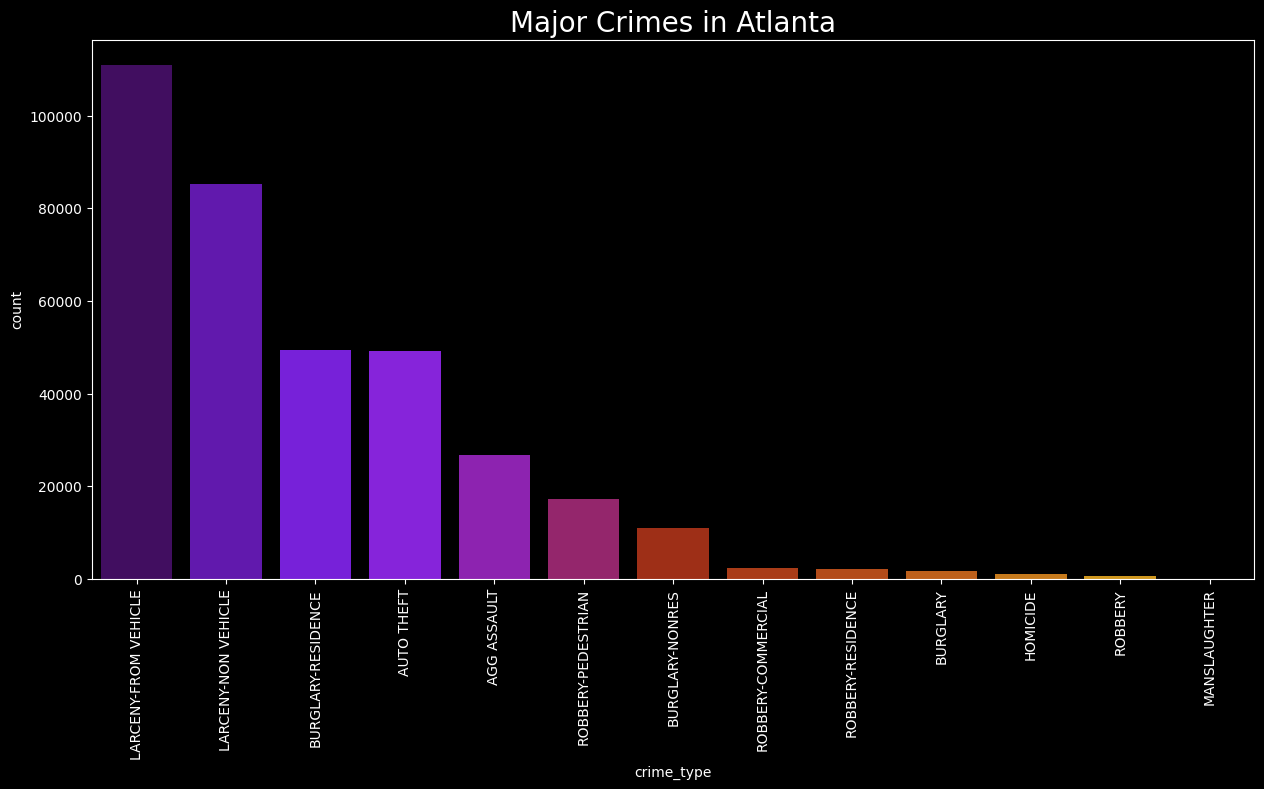

In [ ]:
plt.rcParams['figure.figsize'] = (15, 7)
plt.style.use('dark_background')

sns.countplot(df['crime_type'], palette = 'gnuplot', order = df['crime_type'].value_counts().index)

plt.title('Major Crimes in Atlanta', fontweight = 30, fontsize = 20)
plt.xticks(rotation = 90)
plt.show()

Top 20 Neighborhoods with high crime rate

Frequency of crime at particular time

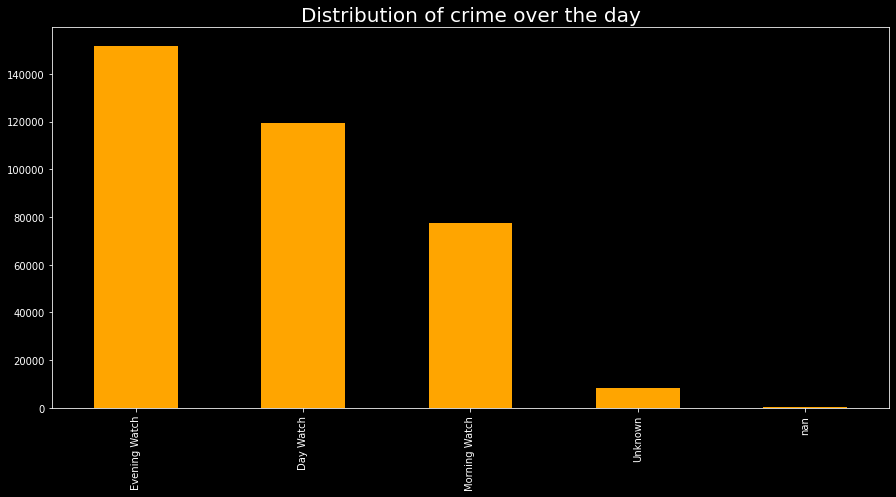

In [ ]:
# checking the time at which crime occurs mostly

import warnings
warnings.filterwarnings('ignore')

color = plt.cm.twilight(np.linspace(0, 5, 100))
df['watch'].value_counts().head(20).plot.bar(color = 'orange', figsize = (15, 7))

plt.title('Distribution of crime over the day', fontsize = 20)
plt.show()


Crime Trend over the Years

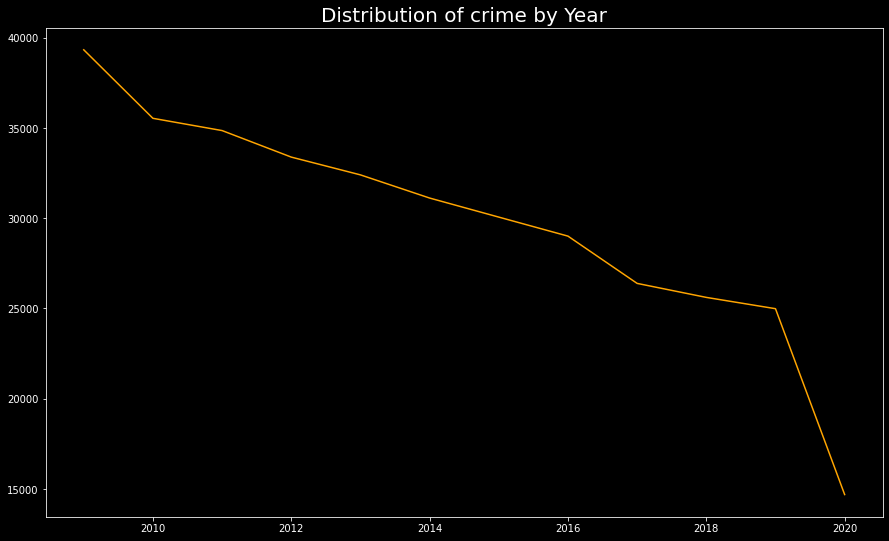

In [ ]:
# checking the time at which crime occurs mostly

import warnings
warnings.filterwarnings('ignore')

color = plt.cm.twilight(np.linspace(0, 5, 100))
df['occur_year'].value_counts().head(20).plot.line(color = 'orange', figsize = (15, 9))
count = df['occur_year'].value_counts()
plt.title('Distribution of crime by Year', fontsize = 20)
plt.show()

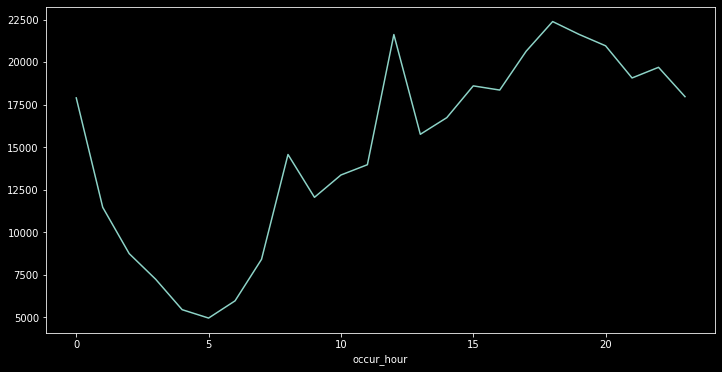

In [ ]:
df.groupby(['occur_hour']).size().plot(figsize=(12,6))

<bound method DataFrame.sort_values of        offense_id   rpt_date occur_date  ... occur_year  occur_hour occur_min
0        90010930 2009-01-01 2009-01-01  ...       2009          11        45
1        90011083 2009-01-01 2009-01-01  ...       2009          13        30
2        90011208 2009-01-01 2009-01-01  ...       2009          15        00
3        90011218 2009-01-01 2009-01-01  ...       2009          14        50
4        90011289 2009-01-01 2009-01-01  ...       2009          16        00
...           ...        ...        ...  ...        ...         ...       ...
14826   202670466 2020-09-23 2020-09-22  ...       2020          18        00
14827   202670717 2020-09-23 2020-09-22  ...       2020          21        30
14828   202680455 2020-09-24 2020-09-23  ...       2020          23        00
14829   202731007 2020-09-29 2020-09-26  ...       2020          18        00
14830   202731640 2020-09-29 2020-09-29  ...       2020          20        30

[357346 rows x 15 column

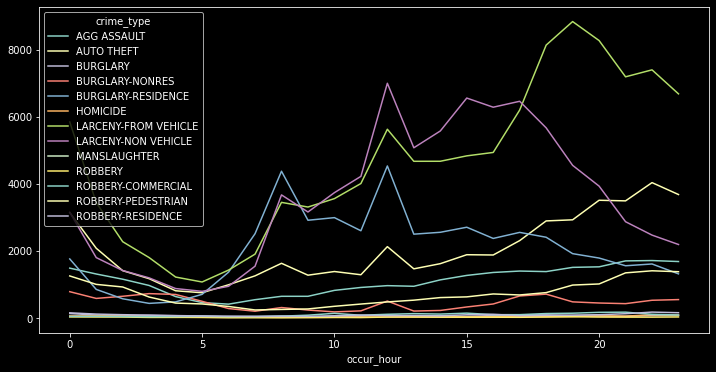

In [ ]:
occur_hour = df.sort_values(by='occur_hour',ascending=True)
df.groupby(['occur_hour', 'crime_type']).size().unstack(level=1).plot(figsize=(12,6))

Locating Crime Density on Map

Locating Crimes on a Street Map

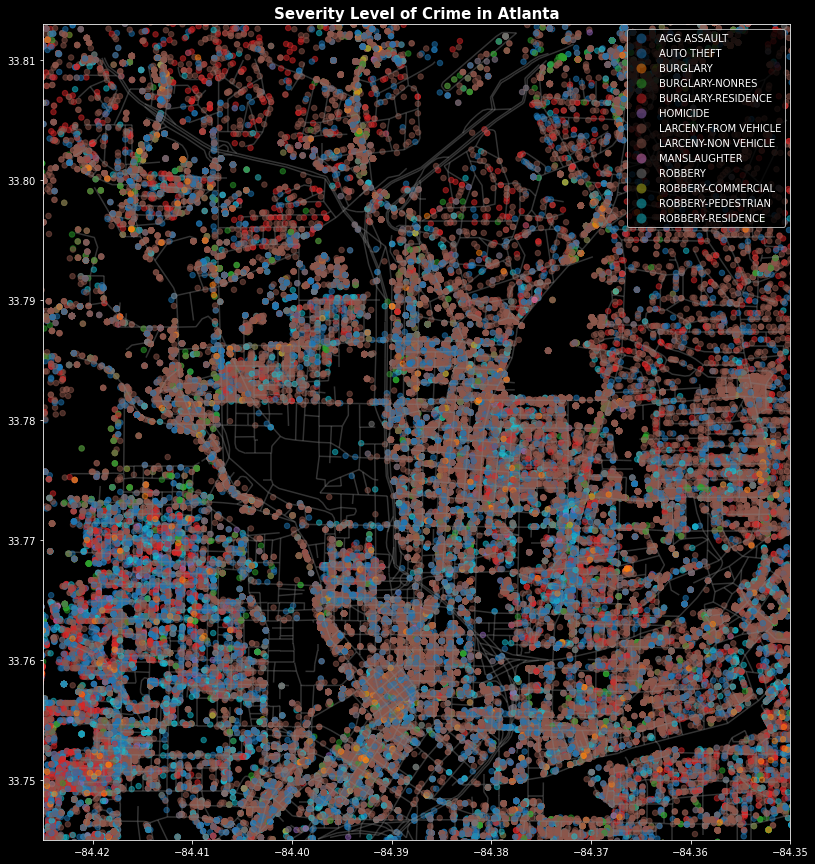

In [ ]:
street_map = gpd.read_file("Roads_Atlanta_GA.shp")
street_map.to_crs(4326)

geometry21 = [Point(xy) for xy in zip(df['long'], df['lat'])]
geo_df21 = gpd.GeoDataFrame(df, crs="EPSG:4326", geometry=geometry21)
geo_df21

fig, ax = plt.subplots(figsize=(15,15))
geo_df21.plot(column="crime_type", ax=ax,alpha=0.5, legend=True,markersize=30)
street_map.to_crs(4326).plot(ax=ax, alpha=0.4,color='grey')
plt.style.use('default')
df.groupby(['neighborhood', 'crime_type']).size()
plt.title('Severity Level of Crime in Atlanta', fontsize=15,fontweight='bold')
# set latitiude and longitude boundaries for map display
plt.xlim(-84.425,-84.35)
plt.ylim( 33.745, 33.813)
plt.show()

In [ ]:
map = folium.Map(location=[df['lat'].mean(), df['long'].mean()])
# add a marker for every record in the filtered data, use a clustered view
marker_cluster = MarkerCluster().add_to(map) # create marker clusters
for i in range(2000): # we can choose any number of incidents to plot on the map, eg: df.shape[0]
    location = [df['lat'][i],df['long'][i]]
    tooltip = "Neighborhood: {}<br> Click for more".format(df["neighborhood"][i])
    folium.Marker(location=[df.iloc[i]['lat'], df.iloc[i]['long']],popup=df.iloc[i]['location']).add_to(marker_cluster)
map.save('map.html')
map

Machine Learning Models

1. K-Means Clustering

Model Preparation

In [ ]:
#preparing Longitude and Latitude data

lis = []

Lat = list(df['lat'])
Long = list(df['long'])

for i in range(len(Lat)):
    li = []
    if Lat[i] > 30 and Long[i] < -40:
        li.append(Lat[i])
        li.append(Long[i])
    else:
        li.append(np.nan)
        li.append(np.nan)
    lis.append(li)

del Lat
del Long

L = np.array(lis)
Latitude = L[:, 0]
Longitude = L[:, 1]

df['lat'] = Latitude
df['long'] = Longitude

df = df.dropna()
df.reset_index(inplace = True)
df.head()

Latitude = list(df['lat'])
Longitude = list(df['long'])

L = [[Latitude[i], Longitude[i]] for i in range(len(Latitude))]

X = np.array(L)
X.shape


(357275, 2)

Model Plotting


Text(0, 0.5, 'Longitude')

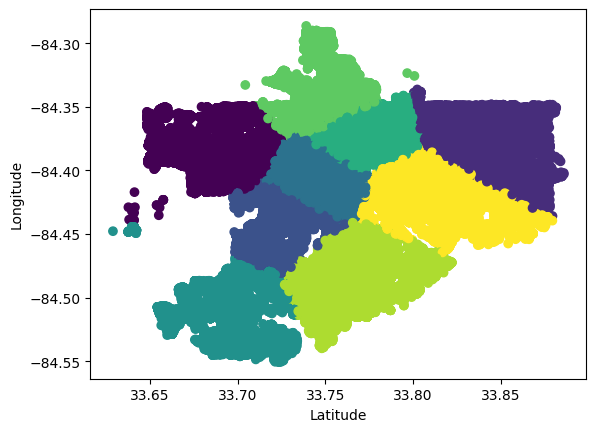

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

kmeans = KMeans(n_clusters = 9, random_state = 0).fit(X)
Clusters = kmeans.labels_.tolist()

# Plot the cluster assignments

plt.scatter(X[:, 0], X[:, 1], c = Clusters)
plt.xlabel("Latitude")
plt.ylabel("Longitude")



Metrics

In [ ]:
#Predict the closest cluster each sample in X belongs to.
kmeans.predict(X, sample_weight=None)


array([4, 3, 7, ..., 6, 6, 3], dtype=int32)

Prediction Based on K-Means Clustering Model

In [ ]:
import itertools 
df['Cluster'] = Clusters
df['Cluster'].value_counts()

abc = df['Cluster'].value_counts()
print("Cluster: Crime counts:\n", abc)
dict(abc)

#print(dict(abc))

abc = dict(itertools.islice(abc.items(), 3))
top_3_clusters = list(abc.keys())

df_top_1 = df[df.Cluster == top_3_clusters[0]]
df_top_2 = df[df.Cluster == top_3_clusters[1]]
df_top_3 = df[df.Cluster == top_3_clusters[2]]

print("\n\nCluster with highest crime density: ", top_3_clusters[0])
print("\nNeighborhoods in that highest crime rate classified cluster are ", set(df_top_1.neighborhood))
print("\n\nCluster with highest crime density: ", top_3_clusters[1])
print("\nNeighborhoods in that highest crime rate classified cluster are ", set(df_top_2.neighborhood))
print("\n\nCluster with highest crime density: ", top_3_clusters[2])
print("\nNeighborhoods in that highest crime rate classified cluster are ", set(df_top_3.neighborhood))

Cluster: Crime counts:
 3    63296
5    62667
7    38485
1    38180
8    36706
0    36185
2    29782
6    29719
4    22255
Name: Cluster, dtype: int64


Cluster with highest crime density:  3

Neighborhoods in that highest crime rate classified cluster are  {'Summerhill', 'Washington Park', 'Atlanta University Center', 'Pittsburgh', 'West End', 'English Avenue', 'Harris Chiles', 'Capitol Gateway', 'Capitol View', 'Bankhead', 'Mozley Park', 'Downtown', 'Grant Park', 'Peoplestown', 'Capitol View Manor', 'Oakland City', 'Ashview Heights', 'Vine City', 'Castleberry Hill', 'Marietta Street Artery', 'Mechanicsville', 'The Villages at Castleberry Hill', 'nan', 'West Lake', 'Hunter Hills', 'Grove Park', 'Oakland', 'Adair Park', 'Just Us'}


Cluster with highest crime density:  5

Neighborhoods in that highest crime rate classified cluster are  {'Inman Park', 'Poncey-Highland', 'Capitol Gateway', 'Old Fourth Ward', 'Morningside/Lenox Park', 'Atkins Park', 'Virginia Highland', 'Downtown', 'Grant

Based on the cluster density

Neighborhoods with top most crime rate

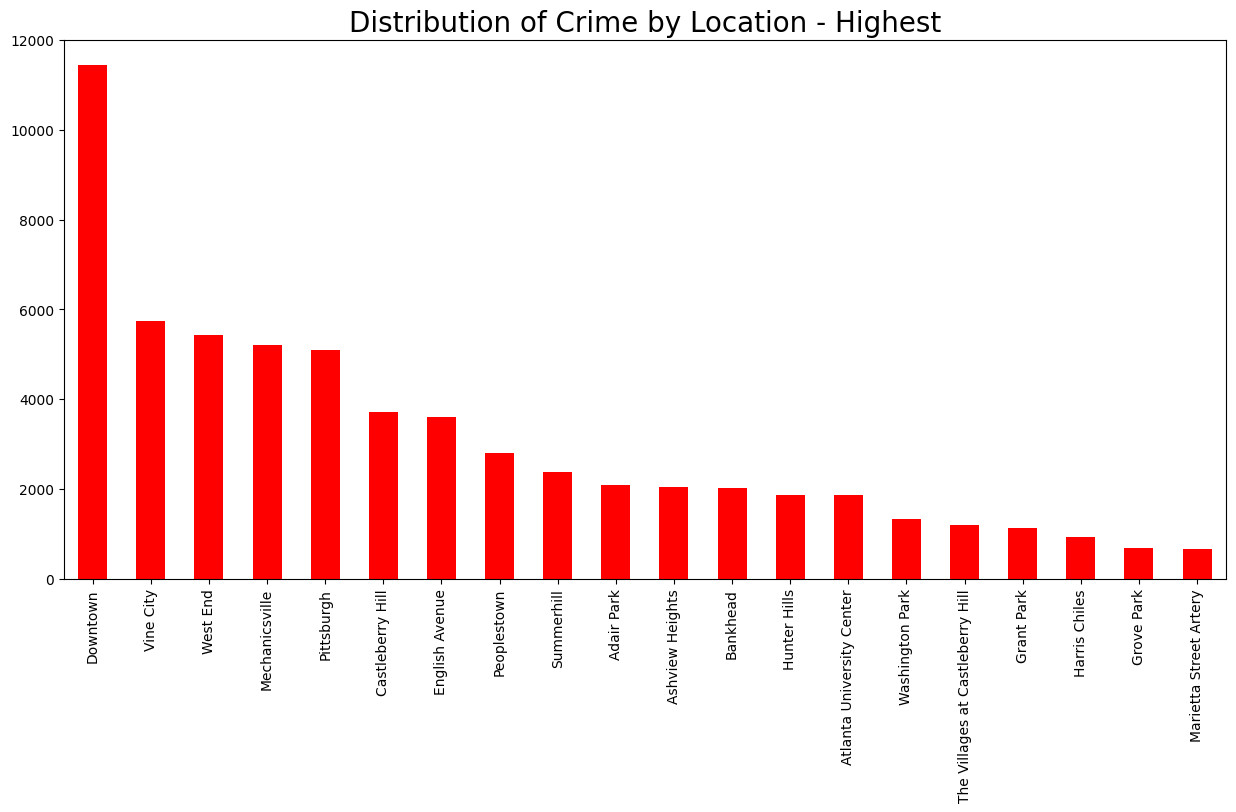

In [ ]:
import warnings
warnings.filterwarnings('ignore')

color = plt.cm.twilight(np.linspace(0, 5, 100))
df_top_1['neighborhood'].value_counts().head(20).plot.bar(color = 'red', figsize = (15, 7))

plt.title('Distribution of Crime by Location - Highest', fontsize = 20)
plt.show()

Neighborhoods with second top most crime rate

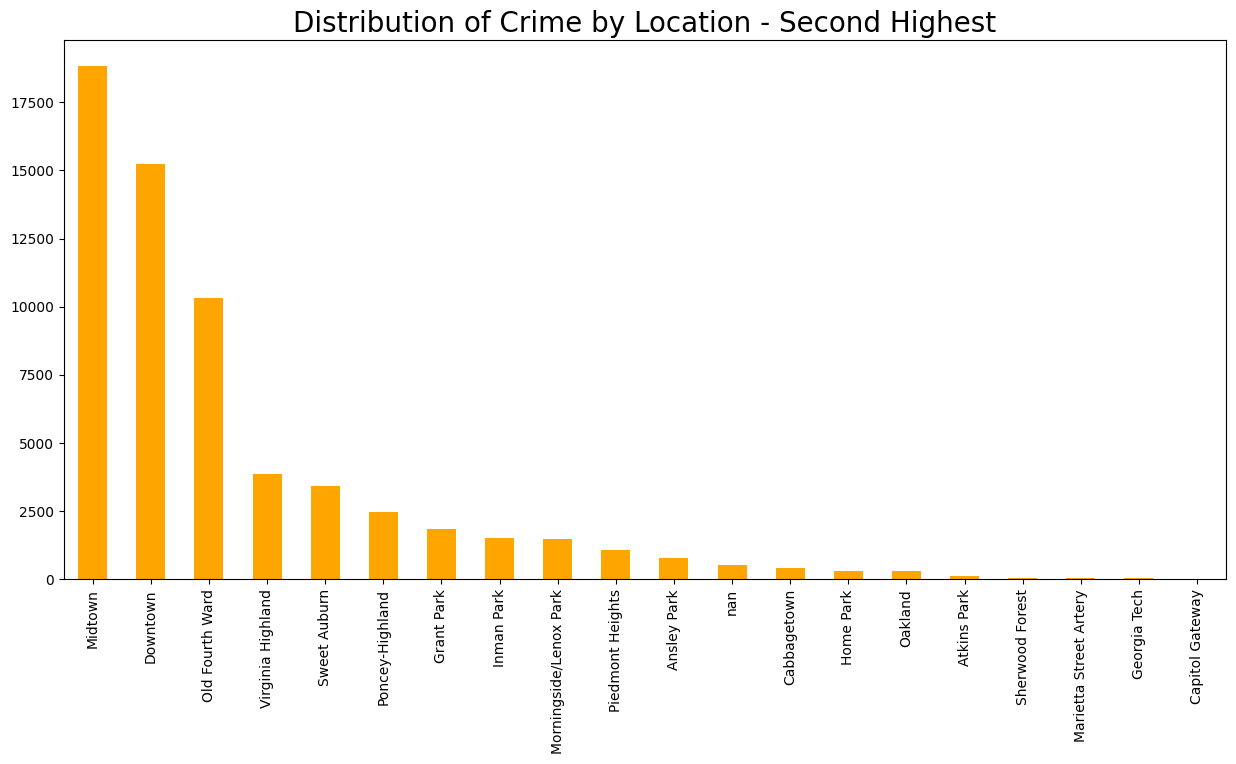

In [ ]:

import warnings
warnings.filterwarnings('ignore')

color = plt.cm.twilight(np.linspace(0, 5, 100))
df_top_2['neighborhood'].value_counts().head(20).plot.bar(color = 'orange', figsize = (15, 7))

plt.title('Distribution of Crime by Location - Second Highest', fontsize = 20)
plt.show()

Neighborhoods with third most crime rate

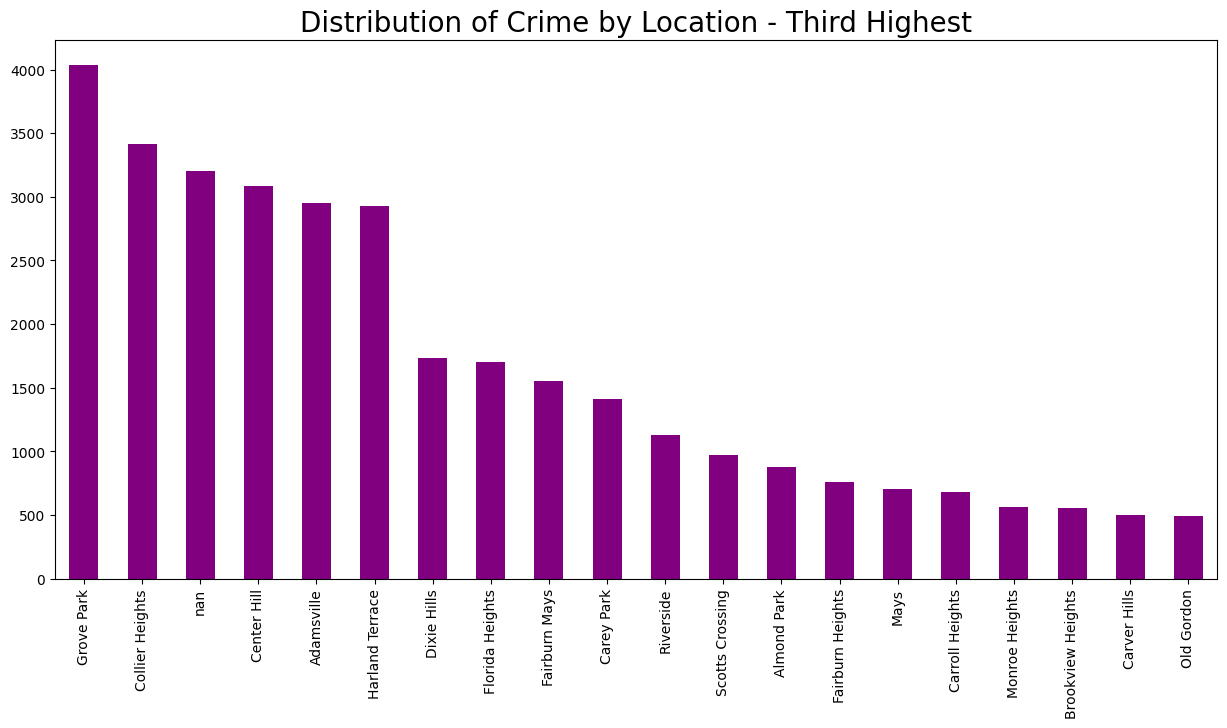

In [ ]:

import warnings
warnings.filterwarnings('ignore')

color = plt.cm.twilight(np.linspace(0, 5, 100))
df_top_3['neighborhood'].value_counts().head(20).plot.bar(color = 'purple', figsize = (15, 7))

plt.title('Distribution of Crime by Location - Third Highest', fontsize = 20)
plt.show()

In [ ]:
data = df.groupby(['occur_year']).size().reset_index()
X = data.iloc[:, :-1].values
y = data.iloc[:, 1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)
reg = LinearRegression()
reg.fit(X_train, y_train)

print(reg.intercept_)
print(reg.coef_)

y_pred = reg.predict(X_test)
r = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
r

2744904.870370371
[-1347.4537037]


Actual     Predicted
0   30059  29785.657407
1   14691  23048.388889
2   32398  32480.564815

In [ ]:
print(reg.intercept_)
print(reg.coef_)

2744904.870370371
[-1347.4537037]


In [ ]:
y_pred = reg.predict(X_test)
r = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(r)
print('')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

   Actual     Predicted
0   30059  29785.657407
1   14691  23048.388889
2   32398  32480.564815

Mean Absolute Error: 2904.432098765547
Mean Squared Error: 23309160.720565323
Root Mean Squared Error: 4827.956163902622


In [ ]:
r2_score = reg.score(X_test,y_test)
print(r2_score*100,'%')

62.21390148490288 %


In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 2927.6666666666665
Mean Squared Error: 23698645.833333332
Root Mean Squared Error: 4868.125494821732


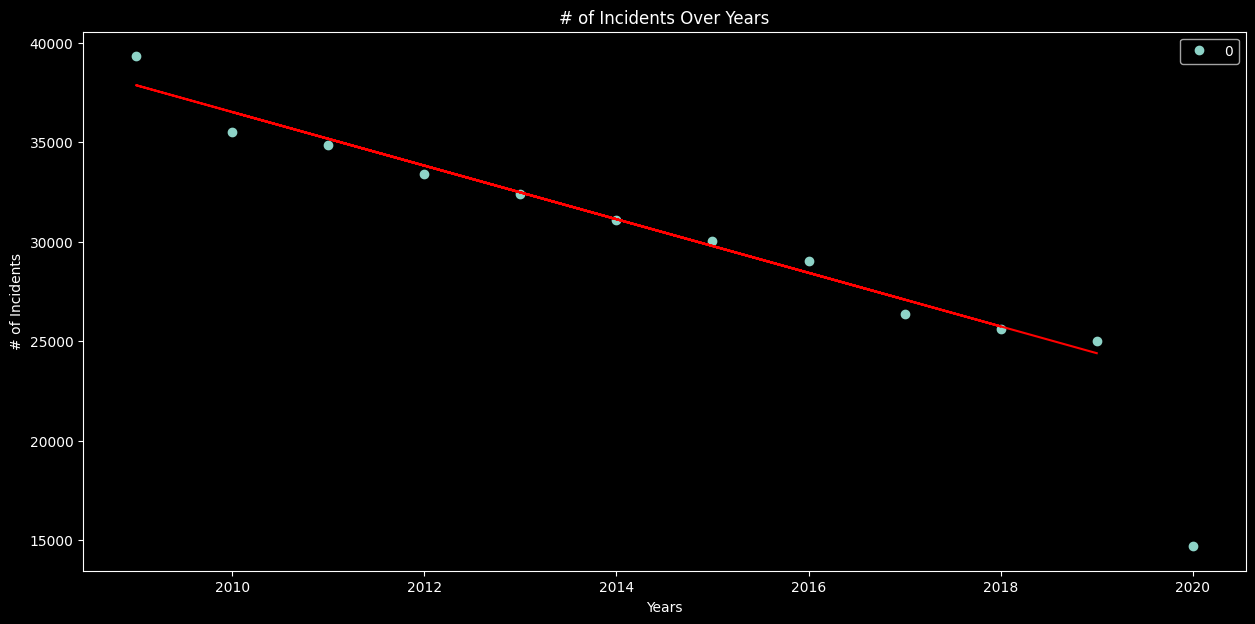

In [ ]:
data.plot(x='occur_year', y=0, style='o')
plt.plot(X_train, reg.predict(X_train), color = "r")
plt.title('# of Incidents Over Years')
plt.xlabel('Years')
plt.ylabel('# of Incidents')
plt.show()